In [1]:
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
def preprocess_text_with_line_numbers(text_lines: list):
    abstracts = {}
    for input_line in text_lines:
        input_line = input_line.strip().lower()
        if input_line.startswith("###"):
            abstract_id = input_line.strip("#")
            abstracts[abstract_id] = []
            continue
        if not input_line:
            continue
        abstracts[abstract_id].append(input_line)
    abstract_samples = []
    for abstract in abstracts:
        total_lines = len(abstracts[abstract]) -1
        for line_num, line in enumerate(abstracts[abstract]):
            line = line.strip()
            caption, text = line.split('\t')
            sample = {}
            sample["abstract_id"] = abstract
            sample["target"] = caption
            sample["text"] = text
            sample["line_number"] = line_num
            sample["total_lines"] = total_lines
            abstract_samples.append(sample)
    return abstract_samples       

In [3]:
def create_tensorboard_callback(experiment_name, model_name):
    """
    Create an tensorboard callback.
    """
    return tf.keras.callbacks.TensorBoard(log_dir=os.path.join("model_logs", experiment_name, model_name))

In [4]:
def create_model_checkpoint_callback(experiment_name, model_name):
    """
     Create an Model Checkpoint callback
    """
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join("model_checkpoints", experiment_name, model_name+".ckpt"),
                                              save_weights_only=True, monitor="val_acc", 
                                              save_best_only=True)

In [5]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-815dd684-e219-0fdd-061d-cf65e500b74c)


In [6]:
# Dataset source
DATASET_SOURCE = "../datasets/pubmed/pubmed-rct"
pubmed_20k_dataset = os.path.join(DATASET_SOURCE, "PubMed_20k_RCT_numbers_replaced_with_at_sign")
train_file = os.path.join(pubmed_20k_dataset, "train.txt")
test_file = os.path.join(pubmed_20k_dataset, "test.txt")
dev_file = os.path.join(pubmed_20k_dataset, "dev.txt")

In [7]:
with open(train_file, "r") as rfile:
    train_lines = rfile.readlines()
with open(test_file, "r") as rfile:
    test_lines = rfile.readlines()
with open(dev_file, "r") as rfile:
    dev_lines = rfile.readlines()

In [8]:
len(train_lines), len(test_lines)

(210040, 35135)

In [9]:
train_lines[0:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
train_abstracts = preprocess_text_with_line_numbers(train_lines)
test_abstracts = preprocess_text_with_line_numbers(test_lines)
dev_abstracts = preprocess_text_with_line_numbers(dev_lines)

In [11]:
len(train_abstracts), len(test_abstracts), len(dev_abstracts)

(180040, 30135, 30212)

In [12]:
train_df = pd.DataFrame(train_abstracts)
test_df = pd.DataFrame(test_abstracts)
val_df = pd.DataFrame(dev_abstracts)

In [13]:
print(train_df.head(), test_df.head(), val_df.head())

  abstract_id     target                                               text  \
0    24293578  objective  to investigate the efficacy of @ weeks of dail...   
1    24293578    methods  a total of @ patients with primary knee oa wer...   
2    24293578    methods  outcome measures included pain reduction and i...   
3    24293578    methods  pain was assessed using the visual analog pain...   
4    24293578    methods  secondary outcome measures included the wester...   

   line_number  total_lines  
0            0           11  
1            1           11  
2            2           11  
3            3           11  
4            4           11     abstract_id      target                                               text  \
0    24845963  background  this study analyzed liver function abnormaliti...   
1    24845963     results  a post hoc analysis was conducted with the use...   
2    24845963     results  liver function tests ( lfts ) were measured at...   
3    24845963     results

In [14]:
train_df.target.value_counts()

methods        59353
results        57953
conclusions    27168
background     21727
objective      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

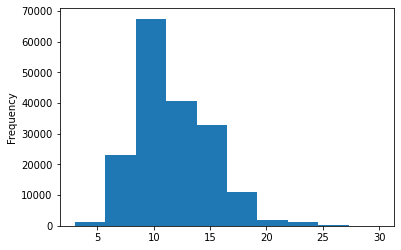

In [15]:
train_df.total_lines.plot.hist()

In [16]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
print(len(train_sentences), len(val_sentences), len(test_sentences))

train_labels = train_df["target"].to_list()
val_labels = val_df["target"].to_list()
test_labels = test_df["target"].to_list()
print(len(train_labels), len(val_labels), len(test_labels))


180040 30212 30135
180040 30212 30135


In [17]:
train_labels[:10]

['objective',
 'methods',
 'methods',
 'methods',
 'methods',
 'methods',
 'results',
 'results',
 'results',
 'results']

In [18]:
# one hot
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(np.array(train_labels).reshape(-1,1))
train_labels_one_hot = one_hot_encoder.transform(np.array(train_labels).reshape(-1,1))
val_labels_one_hot   = one_hot_encoder.transform(np.array(val_labels).reshape(-1,1))
test_labels_one_hot  = one_hot_encoder.transform(np.array(test_labels).reshape(-1,1))
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(train_labels))
train_labels_encoded = label_encoder.transform(np.array(train_labels))
val_labels_encoded = label_encoder.transform(np.array(val_labels))
test_labels_encoded = label_encoder.transform(np.array(test_labels))
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
label_encoder.classes_[4]

'results'

### Base Model

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
    ])
model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
base_preds = model_0.predict(test_sentences)
base_preds

array([2, 2, 2, ..., 4, 4, 4])

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results_score(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)*100
    print(f"[calculate_results_score] the accuracy is :: {model_accuracy}")
    model_precision, model_recall, model_f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    print(f"[calculate_results_score] The precision is : {model_precision}")
    print(f"[calculate_results_score] The recall is : {model_recall}")
    print(f"[calculate_results_score] The f1 score is : {model_f1_score}")
    return {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1_score": model_f1_score,
             }

In [25]:
base_results = calculate_results_score(test_labels_encoded, base_preds)
base_results

[calculate_results_score] the accuracy is :: 71.6674962667994
[calculate_results_score] The precision is : 0.7124322482375202
[calculate_results_score] The recall is : 0.716674962667994
[calculate_results_score] The f1 score is : 0.6925101703856846


{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1_score': 0.6925101703856846}

## Deep model

In [26]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
average_sentence_length = sum(sentence_lengths)/len(train_sentences)
average_sentence_length

26.338269273494777

In [27]:
# average length of the sentences
np.mean(sentence_lengths)

26.338269273494777

In [28]:
# 95 % are under the 55 length
np.percentile(sentence_lengths, 95)

55.0

In [29]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=68000,
                                                    # Default
                                                    # standardize="lower_and_strip_punctuation",
                                                    # output_mode="int",
                                                    output_sequence_length=55)

2022-01-27 20:50:30.610409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 20:50:30.633706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 20:50:30.634579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-27 20:50:30.636121: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [30]:
text_vectorizer.adapt(train_sentences)

In [31]:
text_vectorizer.vocabulary_size()

64841

In [32]:
text_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'of']

In [33]:
embedding = tf.keras.layers.Embedding(input_dim=text_vectorizer.vocabulary_size(),
                                            output_dim=128,
                                            mask_zero=True,
                                            name="token_embedding",
                                       )

In [34]:
embedded_sentence = embedding(text_vectorizer(["The purpose of this experiment is to check if the paitent has covid19"]))
embedded_sentence.shape

TensorShape([1, 55, 128])

In [35]:
# dataset pipeline
train_dataset= tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

Model: "conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 convolution_layer (Conv1D)  (None, 55, 128)           82048     
                                                                 
 pooling_layer (GlobalAverag  (None, 128)              0         
 ePooling1D)                                                     
                                                                 
 output_layer (Dense)        (None, 5)                 6

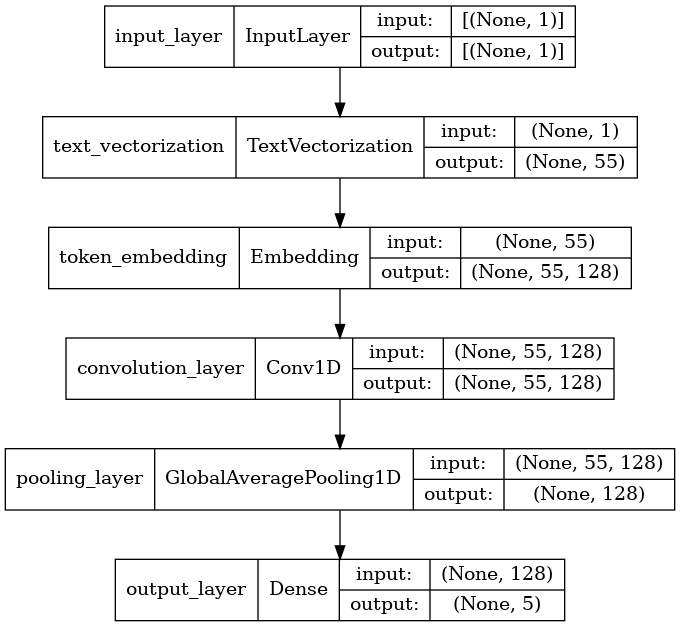

In [37]:
inputs_1 = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
vectorization_layer = text_vectorizer(inputs_1)
embedding_layer = embedding(vectorization_layer)
conv_layer = tf.keras.layers.Conv1D(filters=128,
                                    padding="same",
                                    activation="relu",
                                    kernel_size=5,
                                    name="convolution_layer")(embedding_layer)
pooling_layer = tf.keras.layers.GlobalAveragePooling1D(name="pooling_layer")(conv_layer)
outputs_1 = tf.keras.layers.Dense(units=5, activation="softmax", name="output_layer")(pooling_layer)
model_1 = tf.keras.Model(inputs=inputs_1, outputs=outputs_1, name="conv_model")
model_1.summary()
tf.keras.utils.plot_model(model=model_1, show_shapes=True)

In [38]:
# compile
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [39]:
# fit
model_1_history = model_1.fit(train_dataset,
            validation_data=valid_dataset,
            epochs=5,
            callbacks=[create_model_checkpoint_callback("skimlit", model_1.name),
                      create_tensorboard_callback("skimlit", model_1.name)]
            )

Epoch 1/5


2022-01-27 20:51:00.017007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


5627/5627 [==============================] - 98s 17ms/step - loss: 0.6065 - accuracy: 0.7792 - val_loss: 0.5342 - val_accuracy: 0.8092
Epoch 2/5
5627/5627 [==============================] - 95s 17ms/step - loss: 0.4439 - accuracy: 0.8445 - val_loss: 0.5369 - val_accuracy: 0.8109
Epoch 3/5
5627/5627 [==============================] - 95s 17ms/step - loss: 0.3571 - accuracy: 0.8779 - val_loss: 0.5840 - val_accuracy: 0.8046
Epoch 4/5
5627/5627 [==============================] - 93s 17ms/step - loss: 0.2844 - accuracy: 0.9060 - val_loss: 0.6684 - val_accuracy: 0.7954
Epoch 5/5
5627/5627 [==============================] - 87s 15ms/step - loss: 0.2244 - accuracy: 0.9284 - val_loss: 0.7757 - val_accuracy: 0.7874


In [40]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7757 - accuracy: 0.7874


[0.7757201194763184, 0.7873692512512207]

In [41]:
model_1_pred_probs = model_1.predict(test_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 4, 2, ..., 4, 4, 4])>

In [42]:
model_1_results = calculate_results_score(test_labels_encoded, model_1_preds)
model_1_results

[calculate_results_score] the accuracy is :: 77.84967645594824
[calculate_results_score] The precision is : 0.7755906009135497
[calculate_results_score] The recall is : 0.7784967645594824
[calculate_results_score] The f1 score is : 0.7756303661982095


{'accuracy': 77.84967645594824,
 'precision': 0.7755906009135497,
 'recall': 0.7784967645594824,
 'f1_score': 0.7756303661982095}

In [43]:
base_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1_score': 0.6925101703856846}

Model: "pretrained_embedding_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 fully_connected_layer_a (De  (None, 128)              65664     
 nse)                                                            
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


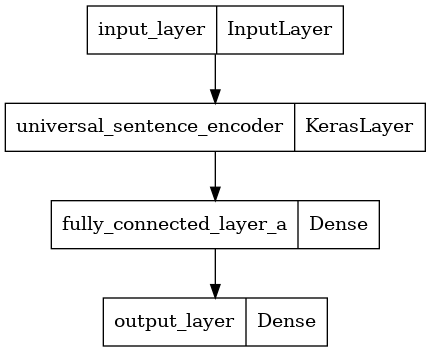

In [44]:
# tf hub pre trained model
inputs_2 = tf.keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")
encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                  trainable=False,
                                  name="universal_sentence_encoder")
embedding_layer = encoder_layer(inputs_2)
fully_connected_layer_a = tf.keras.layers.Dense(units=128, activation="relu", name="fully_connected_layer_a")(embedding_layer)
outputs_2 = tf.keras.layers.Dense(units=5, activation="softmax", name="output_layer")(fully_connected_layer_a)
model_2 = tf.keras.Model(inputs=inputs_2, outputs=outputs_2, name="pretrained_embedding_layer")
model_2.summary()
tf.keras.utils.plot_model(model_2)

In [45]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
model_2_history = model_2.fit(train_dataset,
            validation_data=valid_dataset,
            epochs=5,
            callbacks=[create_model_checkpoint_callback("skimlit", model_2.name ),
                       create_tensorboard_callback("skimlit", model_2.name)]
            )

Epoch 1/5
5626/5627 [============================>.] - ETA: 0s - loss: 0.5488 - accuracy: 0.7932WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 97s 17ms/step - loss: 0.5488 - accuracy: 0.7932 - val_loss: 0.5980 - val_accuracy: 0.7743
Epoch 2/5
5626/5627 [============================>.] - ETA: 0s - loss: 0.5374 - accuracy: 0.7980WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 97s 17ms/step - loss: 0.5374 - accuracy: 0.7980 - val_loss: 0.5995 - val_accuracy: 0.7747
Epoch 3/5
5626/5627 [============================>.] - ETA: 0s - loss: 0.5278 - accuracy: 0.8018WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 110s 20ms/step - loss: 0.5278 - accuracy: 0.8018 - val_loss: 0.6013 - val_accuracy: 0.7744
Epoch 4/5
5625/5627 [============================>.] - ETA: 0s - loss: 0.5193 - accuracy: 0.8047WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 117s 21ms/step - loss: 0.5193 - accuracy: 0.8047 - val_loss: 0.6039 - val_accuracy: 0.7733
Epoch 5/5
5625/5627 [============================>.] - ETA: 0s - loss: 0.5116 - accuracy: 0.8076WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 115s 20ms/step - loss: 0.5116 - accuracy: 0.8076 - val_loss: 0.6069 - val_accuracy: 0.7730


In [48]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.6069 - accuracy: 0.7730


[0.6068759560585022, 0.7730371952056885]

In [49]:
model_2_pred_probs = model_2.predict(test_dataset)
model_2_pred_probs

array([[7.3077485e-02, 2.4881640e-01, 6.8528377e-02, 1.5563951e-01,
        4.5393825e-01],
       [8.5455813e-02, 1.2200125e-02, 5.5239797e-01, 5.0369199e-02,
        2.9957691e-01],
       [5.1791871e-05, 3.9694097e-04, 9.8516256e-01, 3.1269083e-05,
        1.4357479e-02],
       ...,
       [5.0276020e-07, 3.6143477e-03, 1.6913067e-04, 4.0897197e-07,
        9.9621564e-01],
       [1.0914914e-03, 1.4249201e-02, 9.9385506e-04, 1.8506745e-04,
        9.8348039e-01],
       [5.6230188e-03, 8.7004691e-01, 1.8282389e-02, 3.2499591e-03,
        1.0279770e-01]], dtype=float32)

In [50]:
model_2_results = calculate_results_score(test_labels_encoded, tf.argmax(model_2_pred_probs, axis=1))
model_2_results

[calculate_results_score] the accuracy is :: 76.35639621702339
[calculate_results_score] The precision is : 0.7609846528311802
[calculate_results_score] The recall is : 0.7635639621702339
[calculate_results_score] The f1 score is : 0.7594144995756628


{'accuracy': 76.35639621702339,
 'precision': 0.7609846528311802,
 'recall': 0.7635639621702339,
 'f1_score': 0.7594144995756628}

In [51]:
model_1_results

{'accuracy': 77.84967645594824,
 'precision': 0.7755906009135497,
 'recall': 0.7784967645594824,
 'f1_score': 0.7756303661982095}

In [52]:
base_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1_score': 0.6925101703856846}

### Character level encoding model

In [60]:
def split_chars(text):    
    return " ".join(list(text))

In [63]:
train_chars  = [split_chars(text) for text in train_sentences]
valid_chars  = [split_chars(text) for text in val_sentences]
test_chars  = [split_chars(text) for text in test_sentences]
train_chars[:1]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .']

In [66]:
np.mean([len(sentence) for sentence in train_sentences])

149.3662574983337

In [ ]:
np.mean([len(sentence) for sentence in train_sentences])

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

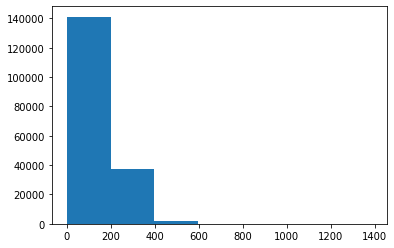

In [68]:
plt.hist([len(sentence) for sentence in train_sentences], bins=7)

In [69]:
np.percentile([len(sentence) for sentence in train_sentences], 95)

290.0

In [71]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
NUM_CHAR_TOKENS = len(alphabet) + 2
NUM_CHAR_TOKENS

70

In [79]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    output_sequence_length=290,
                                                    name="character_vectorizer")
char_vectorizer.adapt(train_chars)

In [80]:
char_vectorizer.get_config()

{'name': 'character_vectorizer',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 70,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 290,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [81]:
char_vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'e', 't', 'i']

In [82]:
char_vectorizer.vocabulary_size()

28

In [83]:
char_embed = tf.keras.layers.Embedding(input_dim=char_vectorizer.vocabulary_size(),
                                       output_dim=25,
                                       mask_zero=True,
                                       name="char_embed")
char_embed

In [87]:
char_embed(char_vectorizer(["This is a text"]))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 4.5696124e-03, -4.3766387e-03,  2.1495666e-02, ...,
         -2.8046513e-02, -2.5689591e-02, -1.6843535e-02],
        [ 4.5696124e-03, -4.3766387e-03,  2.1495666e-02, ...,
         -2.8046513e-02, -2.5689591e-02, -1.6843535e-02],
        [-6.5860860e-03, -1.3493694e-02,  4.2464200e-02, ...,
         -2.8051961e-02, -1.3043940e-02,  2.2825126e-02],
        ...,
        [ 4.4175159e-02, -2.7585829e-02,  8.4109195e-03, ...,
         -1.8310796e-02, -8.1527978e-05, -3.2652691e-02],
        [ 4.4175159e-02, -2.7585829e-02,  8.4109195e-03, ...,
         -1.8310796e-02, -8.1527978e-05, -3.2652691e-02],
        [ 4.4175159e-02, -2.7585829e-02,  8.4109195e-03, ...,
         -1.8310796e-02, -8.1527978e-05, -3.2652691e-02]]], dtype=float32)>

Model: "char_embedding_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 char_embed (Embedding)      (None, 55, 25)            700       
                                                                 
 convolution_layer (Conv1D)  (None, 55, 64)            8064      
                                                                 
 pooling_layer (GlobalMaxPoo  (None, 64)               0         
 ling1D)                                                         
                                                                 
 output_layer (Dense)        (None, 5)        

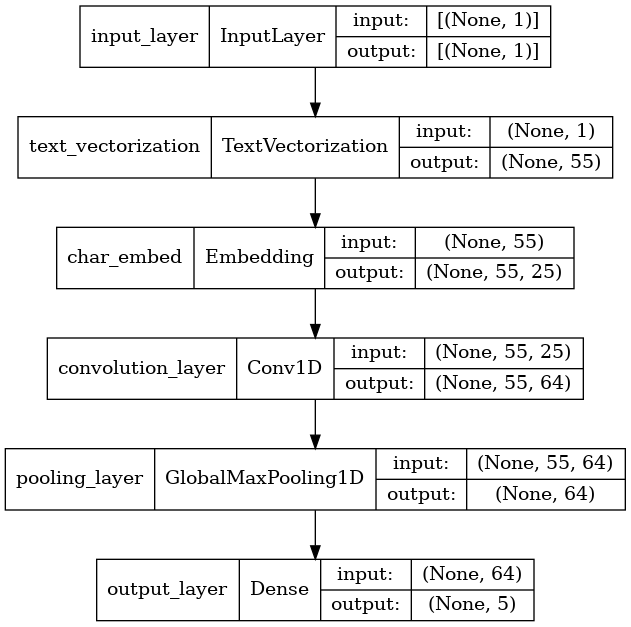

In [99]:
inputs_3 = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
vectorization_layer = text_vectorizer(inputs_3)
embedding_layer = char_embed(vectorization_layer)
convolution_layer = tf.keras.layers.Conv1D(filters=64,
                                           kernel_size=5,
                                           padding="same",
                                           activation="relu",
                                           name="convolution_layer")(embedding_layer)
pooling_layer = tf.keras.layers.GlobalMaxPool1D(name="pooling_layer")(convolution_layer)
outputs_3 = tf.keras.layers.Dense(units=5,
                                  activation="relu",
                                  name="output_layer")(pooling_layer)
model_3 = tf.keras.Model(inputs=inputs_3, outputs=outputs_3, name="char_embedding_model")
model_3.summary()
tf.keras.utils.plot_model(model=model_3, show_shapes=True)

In [100]:
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [101]:
# dataset pipeline
train_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [102]:
history_model_3 = model_3.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs=5,
                        callbacks=[create_model_checkpoint_callback("skimlit", model_3.name),
                                   create_tensorboard_callback("skimlit", model_3.name)])

Epoch 1/5
5624/5627 [============================>.] - ETA: 0s - loss: 5.0780 - accuracy: 0.3616WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 50s 9ms/step - loss: 5.0780 - accuracy: 0.3616 - val_loss: 4.9716 - val_accuracy: 0.3736
Epoch 2/5
5627/5627 [==============================] - ETA: 0s - loss: 5.0613 - accuracy: 0.3727WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 50s 9ms/step - loss: 5.0613 - accuracy: 0.3727 - val_loss: 4.9697 - val_accuracy: 0.3760
Epoch 3/5
5622/5627 [============================>.] - ETA: 0s - loss: 5.0612 - accuracy: 0.3752WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 49s 9ms/step - loss: 5.0618 - accuracy: 0.3752 - val_loss: 4.9747 - val_accuracy: 0.3799
Epoch 4/5
5625/5627 [============================>.] - ETA: 0s - loss: 5.0573 - accuracy: 0.3762WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 48s 9ms/step - loss: 5.0573 - accuracy: 0.3761 - val_loss: 4.9706 - val_accuracy: 0.3791
Epoch 5/5
5624/5627 [============================>.] - ETA: 0s - loss: 5.0533 - accuracy: 0.3776WARNING:tensorflow:Can save best model only with val_acc available, skipping.


5627/5627 [==============================] - 48s 8ms/step - loss: 5.0534 - accuracy: 0.3776 - val_loss: 4.9642 - val_accuracy: 0.3793


In [103]:
model_3.evaluate(valid_dataset)

945/945 [==============================] - 5s 6ms/step - loss: 4.9642 - accuracy: 0.3793


[4.9641547203063965, 0.3793194890022278]

In [104]:
model_3_preds_probs = model_3.predict(test_dataset)
model_3_preds_probs

array([[ 0.        ,  0.        , 10.015037  ,  1.8701875 ,  9.286305  ],
       [ 0.        ,  0.        ,  9.635553  ,  1.9479971 ,  8.079236  ],
       [ 0.        ,  0.        ,  5.782653  ,  1.7040209 ,  7.973432  ],
       ...,
       [ 0.        ,  0.        ,  7.8424625 ,  3.0429387 ,  6.815943  ],
       [ 0.        ,  0.        , 11.293951  ,  0.71027607,  9.249365  ],
       [ 0.        ,  0.        ,  6.0624094 ,  1.9416094 ,  8.290555  ]],
      dtype=float32)

In [105]:
model_3_results = calculate_results_score(test_labels_encoded, tf.argmax(model_3_preds_probs, axis=1))

[calculate_results_score] the accuracy is :: 37.999004479840714
[calculate_results_score] The precision is : 0.24716643290727267
[calculate_results_score] The recall is : 0.37999004479840714
[calculate_results_score] The f1 score is : 0.29760518618802423


/home/arun/learn/tensorflow_certification/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
